## TrumpWorld - analysing companies by country

I'll try to cross-reference the TrumpWorld dataset (specifically, the org-org one) with OpenCorporates.com to gather as much national data as possible for these companies and attribute them a country.

In [1]:
%matplotlib notebook

In [2]:
import sys
import json
import requests
import urllib2 as url
import pandas as pd
import numpy as np
import networkx as nx
from difflib import SequenceMatcher

In [5]:
# First step is loading the .csv and gathering all unique company names
tw_orgorg = pd.read_csv('https://query.data.world/s/94g9v4tj3pzz3ir495y8s3esl')
tw_perorg = pd.read_csv('https://query.data.world/s/50ivsaqkos6vzdf4m51ntq7qc')
tw_perper = pd.read_csv('https://query.data.world/s/dkv4bq3zmtjl72ydaa8trocmw')

In [6]:
# Now we load the OpenCorporates raw data
oc_raw_data = json.load(open('org_OCdata.json'))

In [184]:
# Let's categorize the relationships...
rel_n = 20
print "Top {0} relationships:".format(rel_n)
tw_orgorg.Connection.value_counts()[:rel_n]

Top 20 relationships:


Ownership                                                                   317
Investor                                                                     90
Owns collateralized debt                                                     54
Subsidiary                                                                   51
NKA/FKA                                                                      33
DBA                                                                          16
Loaned money                                                                 12
Mortgage                                                                      6
Business partnership                                                          5
Real-estate partner                                                           4
Tenant                                                                        3
Part of tri-merger to form Colony NorthStar                                   3
Bought building                         

Ten most common relationships involve Ownership, being a Subsidiary, and being "Now Known As/Formerly Known As" or "Doing Business As", namely literally being the same thing.

We should first and foremost merge companies into single blobs if they just are the same thing under different names. Ownership and Subsidiary will instead be considered as links.

In [185]:
# Create a Graph
org_conn = nx.Graph()
# Nodes are companies
org_conn.add_nodes_from(oc_raw_data.keys())
# Connections are only identities
for i, row in tw_orgorg[(tw_orgorg['Connection'] == 'NKA/FKA') |\
                        (tw_orgorg['Connection'] == 'DBA') |\
                        (tw_orgorg['Connection'] == 'AKA')].iterrows():
    org_conn.add_edge(row['Organization A'], row['Organization B'])

# Now find subtrees
conglomerates = [c for c in nx.connected_components(org_conn)]

In [186]:
# These are the unique conglomerates
print "Found {0} conglomerates for {1} companies".format(len(conglomerates), len(org_conn.nodes()))
print "Maximum conglomerate size is {0}".format(max([len(c) for c in conglomerates]))

Found 1557 conglomerates for 1608 companies
Maximum conglomerate size is 3


In [113]:
# Problem: some entries won't have any results, some will have multiple ones, so we need to purge them
oc_data = {org: oc_raw_data[org] for org in oc_raw_data if len(oc_raw_data[org]) > 1}

print "Results existing for {0} organizations out of {1}".format(len(oc_data), len(oc_raw_data))
missing_orgs = set(oc_raw_data.keys())-set(oc_data.keys())

Results existing for 851 organizations out of 1608


In [114]:
# How many of these have info?
tot = 0
addr = 0
jdc = 0
sdate = 0

for org in oc_data:
    for o in oc_data[org]:
        tot += 1
        addr += o['company']['registered_address'] is not None
        jdc += o['company']['jurisdiction_code'] is not None
        sdate += o['company']['created_at'] is not None
    
print "Addresses: {0}/{1}".format(addr, tot)
print "Jurisdiction codes: {0}/{1}".format(jdc, tot)
print "Creation dates: {0}/{1}".format(sdate, tot)

Addresses: 6266/10268
Jurisdiction codes: 10268/10268
Creation dates: 10268/10268


We can see that Addresses can be missing, but Jurisdiction codes and creation dates are always present. This suggests that they may be more reliable to use. What would be needed is a correspondence to a more 'human readable' format for them (which country they represent etc).

In [115]:
# Now for the ones with multiple results
org_alive = {}
org_dead = {}
    
for org in oc_data:
    orgs = oc_data[org]
    # First, remove all the dissolved ones
    dead_orgs = [o for o in orgs if o['company']['dissolution_date'] is not None]
    if len(dead_orgs) > 0:
        org_dead[org] = dead_orgs
    orgs = [o for o in orgs if o['company']['dissolution_date'] is None]
    if len(orgs) == 0:
        continue
    # Still not only one? Look for the one whose name matches best!
    matches = np.array([SequenceMatcher(None, org, o['company']['name']).ratio() for o in orgs])
    best_match = np.amax(matches)
    # Is there only one?
    match_i = np.where(np.isclose(matches, best_match))[0]
    # If there's multiple ones, no helping it, we keep 'em all
    org_alive[org] = np.array(orgs)[match_i]

print "Good match(es) found for {0} organizations still existing".format(len(org_alive))

Good match(es) found for 849 organizations still existing


In [116]:
from datetime import datetime as dt
# Time parsing 
date_fmt = '%Y-%m-%dT%H:%M:%S+00:00'

In [152]:
# Load country/state data
country_codes = json.load(open('country_codes.json'))
state_codes = json.load(open('state_codes.json'))

def read_jur_code(jc):
    cs = jc.split('_')
    if len(cs) > 1:
        c, s = cs
        try:
            country = country_codes[c.upper()]
        except KeyError:
            country = None
        try:
            state = state_codes[s.upper()]
        except KeyError:
            state = None
    else:
        try:
            country = country_codes[jc.upper()]
        except KeyError:
            country = None
        state = None
    return country, state

In [213]:
# Now to try and extract country, time of foundation, and jurisdiction code for each of these
org_table = []

country_contradictions = [] # Store any contradictions found in country between address and jurisdiction code

for org in org_alive:
    orgs = org_alive[org]
    # Columns: organization, country, confidence of country, time of foundation, jurisdiction code
    # Remove organizations without address info, sort by creation date
    orgs = sorted(orgs, key=lambda o: dt.strptime(o['company']['created_at'], date_fmt))
    # Countries?
    address_country = [o['company']['registered_address']['country'] if o['company']['registered_address'] is not None else None for o in orgs]
    jur_country, jur_state = zip(*[read_jur_code(o['company']['jurisdiction_code']) for o in orgs])
    # Any contradictions?
    same_country = [address_country[i] is None or jc.upper() == address_country[i].upper() for i, jc in enumerate(jur_country)]
    if False in same_country:
        contr_i = np.where(np.array(same_country) == False)[0]
        for i in contr_i:
            country_contradictions.append((orgs[i]['company']['name'], address_country[i], jur_country[i]))
    # How many?
    for i, o in enumerate(orgs):
        name = o['company']['name']
        country = jur_country[i]
        state = jur_state[i]
        date = dt.strptime(o['company']['created_at'], date_fmt)
        org_table.append({'Name': name,
                          'Country': country,
                          'State': state,
                          'CreationDate': date,
                          'TWName': org})

In [214]:
# List of address/jurisdiction contradictions
# Remove a very common source of confusion first...
country_contradictions = [c for c in country_contradictions if not (c[1] == 'USA' and c[2] == 'United States')]
print country_contradictions

[(u'GITHUB B.V.', u'Netherlands', u'France'), (u'AETOS TECH SA', u'Switzerland', u'France'), (u'SOCIETY OF PETROLEUM ENGINEERS TRONDHEIM', u'Norge', u'Norway'), (u'AMWAY', u'US', u'France'), (u'GE ASSET MANAGEMENT', u'United Kingdom', u'France'), (u'CITIBANK', u'Allemagne (R\xe9p.f\xe9d.)', u'Belgium'), (u'THE PORT AUTHORITY OF NEW YORK AND NEW JERSEY', u'Grande-Bretagne', u'Belgium'), (u'THE PORT AUTHORITY OF NEW YORK AND NEW JERSEY', u"Etats-Unis d'Am\xe9rique", u'Belgium'), (u'NEW YORK MERCANTILE EXCHANGE', u'UNITED STATES', u'United Kingdom'), (u'BANK HAPOALIM B.M.', u'Israel', u'United Kingdom'), (u'BANK HAPOALIM B.M.', u'ISRAEL', u'United Kingdom'), (u'JONES DAY', u"Etats-Unis d'Am\xe9rique", u'Belgium'), (u'AIG GLOBAL REAL ESTATE INVESTMENT CORP.', u'US', u'France'), (u'PRINCETON UNIVERSITY PRESS', u'United States', u'United Kingdom'), (u'PRINCETON UNIVERSITY PRESS', u'UNITED STATES', u'United Kingdom'), (u'CAMBRIDGE ANALYTICA LTD', u'England', u'United Kingdom'), (u'DEUTSCHE BA

In [215]:
# Now, what kind of connection has Trump with these companies?
tw_perorg[tw_perorg.Person == 'DONALD J. TRUMP'].Connection.value_counts()

President                                                                  477
Member                                                                      27
Partner                                                                     13
Trustee                                                                      9
Chairman                                                                     6
Director                                                                     5
Business partner                                                             3
Member of the Board                                                          2
Ownership                                                                    1
Manager                                                                      1
Loans                                                                        1
Became "the new face of [the] company" in 2009, per the Washington Post      1
President / governor                                

In [216]:
# Define 'strong' connections (valid ones for links)
perorg_strong = ['President', 'Trustee', 'Chairman', 'Director', 'Ownership', 
                 'Manager', 'President / governor', 'Former chairman/CEO', 'Chairman and president']
orgorg_strong = ['Ownership', 'Subsidiary', 'Co-owner']

In [218]:
holdings_graph = nx.Graph()
# Add a special node, Donald J. Trump
holdings_graph.add_node('DONALD J. TRUMP')
# Add all organizations as nodes
holdings_graph.add_nodes_from(oc_raw_data.keys())
# Now connections. First, direct Donald-to-organization ones
for i, row in tw_perorg[tw_perorg.Person == 'DONALD J. TRUMP'].iterrows():
    if row.Connection in perorg_strong:
        holdings_graph.add_edge('DONALD J. TRUMP', row.Organization)
# Then between organizations
for i, row in tw_orgorg.iterrows():
    if row.Connection in orgorg_strong:
        holdings_graph.add_edge(row['Organization A'], row['Organization B'])

In [220]:
# Now compute distances and add them to org_table
for row in org_table:
    try:
        dist = nx.shortest_path_length(holdings_graph, 'DONALD J. TRUMP', row['TWName'])
    except nx.NetworkXNoPath:
        dist = None
    row['TrumpDistance'] = dist

In [221]:
# Ok, so store this info in a database
org_dframe = pd.DataFrame(org_table)
org_dframe.to_csv('org_country.csv', encoding='utf-8')

### Analysis

Here's the N topmost occurring countries

<IPython.core.display.Javascript object>


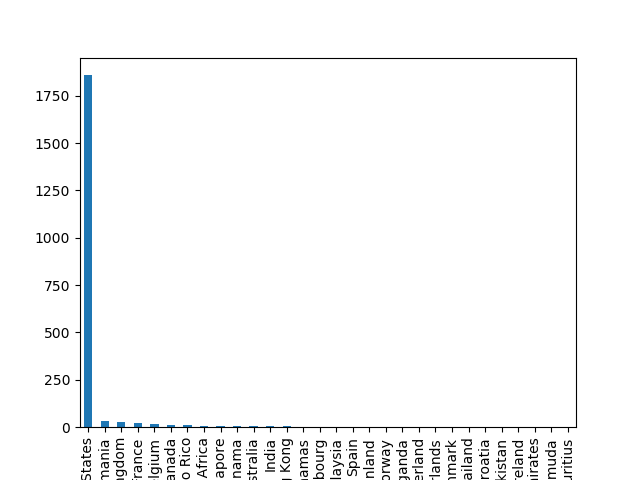

In [234]:
N = 30
org_dframe['Country'].value_counts()[:N].plot(kind='bar')

In [236]:
# State by state
org_dframe['State'].value_counts()

Delaware                399
New York                258
California              134
Florida                 124
New Jersey               78
Texas                    64
Nevada                   51
District Of Columbia     49
Oklahoma                 38
Massachusetts            32
Missouri                 31
Maryland                 30
Arizona                  29
Connecticut              29
Pennsylvania             29
Kentucky                 27
Georgia                  26
North Dakota             24
Michigan                 23
Virginia                 20
Washington               19
Louisiana                19
South Carolina           19
Wisconsin                18
West Virginia            18
Ohio                     18
Oregon                   18
Iowa                     17
Colorado                 17
Hawaii                   16
Vermont                  16
Arkansas                 14
New Mexico               14
Indiana                  14
Idaho                    14
Mississippi         

In [235]:
# Histogram of distances
org_dframe['TrumpDistance'].value_counts()

1.0    349
2.0     56
3.0      6
Name: TrumpDistance, dtype: int64